## Vector-valued function with Random Fourier Features

### Imports

In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

### Values

In [2]:
dimension = 2
sigma = 10
sigma2 = 2*sigma**2

# Random Fourier features
m = 20 # number of samples
w = np.array([randn(m) / sigma, randn(m) / sigma]) # w is the same size as the dimensions times the number of samples
b = np.random.rand(m)*2*np.pi # b is the same size as number of samples

n = 500 # number of points

x1 = randn(n)/2
x2 =  randn(n)/2
x_vector = np.array([x1, x2])
# x_vector = np.block([x1,x2])

noise = randn(n) * 1e-1
#y1 = np.cos(x1) + noise
#y2 = np.sin(x2) + noise

y1 = 1+np.sin(x1/10) + x1**2 + noise
y2 = 0.5 * x2**2 + np.exp(x2) + noise

y = np.array(np.ravel([y1, y2], 'F'))

lam = 0.000001 # Regularization parameter
y.shape

(1000,)

### Gaussian Kernel

In [3]:
def k_gauss(x, z):
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def k_matrix(x, z, dim):
    k = k_gauss(x, z)
    k_matrix = k *np.eye(dim)
    return k_matrix

def K_gauss(x, n, dim):
    K = np.zeros((dim*n, dim*n))
    for i in range(0, n):
        for j in range(0, n):
            k = k_gauss(x[:,i], x[:,j])
            K[i*dim][j*dim] = k
            K[i*dim+1][j*dim+1] = k
    return K

K = K_gauss(x_vector, n, dimension)
K

array([[1.        , 0.        , 0.99361498, ..., 0.        , 0.98469484,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.98577639, 0.        ,
        0.98469484],
       [0.99361498, 0.        , 1.        , ..., 0.        , 0.99790705,
        0.        ],
       ...,
       [0.        , 0.98577639, 0.        , ..., 1.        , 0.        ,
        0.99976024],
       [0.98469484, 0.        , 0.99790705, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.98469484, 0.        , ..., 0.99976024, 0.        ,
        1.        ]])

#### Alpha

In [4]:
# Returns a vector with length dim * n
def alpha(x, y, lam, n, dim):
    K = K_gauss(x, n, dim)
    alpha_vector = np.linalg.inv((K + lam*np.eye(dim*n))) @ y
    alpha_reshape = [alpha_vector[::2], alpha_vector[1::2]]
    return np.array(alpha_reshape)

alpha_ = alpha(x_vector, y, lam, n, dimension)
alpha_

array([[-1.59959441e+03, -7.49445686e+04,  1.70749304e+05,
         1.76477352e+03, -4.18464812e+04,  3.09820584e+03,
         8.59477657e+04, -1.39648466e+04, -1.37753100e+05,
        -5.72663255e+04, -1.13590260e+05, -1.33417002e+05,
         9.59879600e+04,  1.64991167e+05,  1.32115524e+04,
        -1.18319992e+05,  3.44528049e+04, -2.32032392e+04,
         9.36994078e+04,  8.43078451e+04, -7.83820104e+04,
        -2.88174824e+04, -2.23240791e+04,  2.01486501e+05,
         1.40197924e+05,  8.40803705e+04,  1.01468664e+05,
         1.59461600e+05,  1.40776025e+04, -3.93782355e+02,
        -1.84007840e+04, -1.57880882e+05,  2.99882398e+03,
        -9.76204341e+04, -7.59323993e+04, -9.78528873e+04,
         1.31829724e+04,  1.31856788e+03,  5.33577587e+04,
         1.44183752e+05,  9.17337912e+04, -3.42694532e+04,
         5.49033258e+04, -3.41574613e+04, -8.79074726e+04,
         6.44530157e+04,  4.72012321e+04,  3.30420623e+04,
        -4.35187124e+04,  1.01799999e+04,  2.10762972e+0

#### Estimated function

In [5]:
def estimated_function(alpha, x, n, dim):
    function = np.zeros((2, n))
    for i in range(n):
        sum = np.zeros((2))
        x_i = x[:, i]
        for j in range(n):
            k = k_gauss(x_i, x[:, j])
            kernel = k*np.eye(dim)
            sum = sum + kernel@alpha[:, j]
        function[:, i] = sum 
    return function

func = estimated_function(alpha_, x_vector, n, dimension)
func

array([[1.00921131, 1.35786321, 1.08759281, 1.58449741, 1.08657241,
        1.07390228, 1.48477852, 1.07556816, 1.00289845, 1.01705561,
        1.2446331 , 1.07438604, 1.14326421, 1.53412523, 1.17933877,
        1.54088704, 1.26499913, 1.02810431, 1.04409802, 1.23064225,
        1.3250216 , 1.47172591, 1.42128633, 1.033204  , 0.99614755,
        1.00453615, 1.05220146, 1.01752106, 1.11566938, 1.13591053,
        1.34040887, 1.13083579, 1.06662621, 1.14802928, 1.01891032,
        1.46129197, 1.27746105, 1.24370647, 1.11562833, 1.19724971,
        1.13466965, 1.0154038 , 0.99938628, 1.48305158, 1.00294663,
        1.3192821 , 0.99526123, 1.13442605, 1.09744511, 1.13720713,
        1.09019836, 1.00223335, 1.04433347, 1.56362127, 1.14921906,
        1.281882  , 1.05264204, 1.02576627, 1.60518858, 1.07113122,
        0.99381543, 2.34096449, 1.00326839, 1.37689325, 1.21899685,
        1.12142563, 1.02731547, 0.99381422, 1.17394041, 1.0087641 ,
        1.53751788, 1.06435597, 1.00273481, 1.41

#### Plot

C:\Users\vilde\AppData\Local\Temp\ipykernel_13192\2062984262.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\vilde\AppData\Local\Temp\ipykernel_13192\2062984262.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


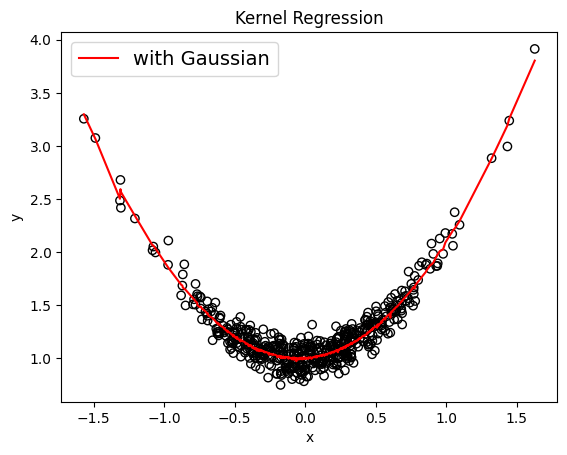

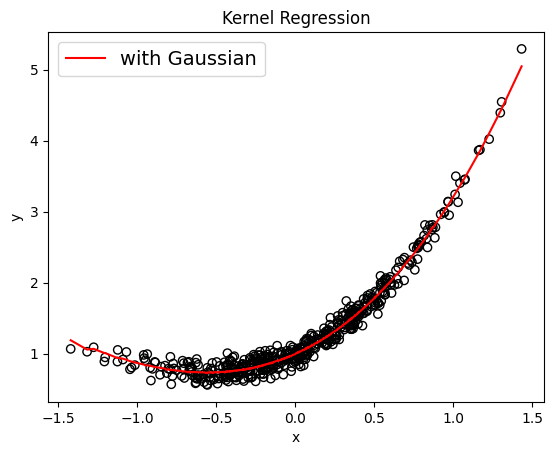

In [6]:
# Plot for x1 and y1
f1_sort = np.array([x for _,x in sorted(zip(x1,func[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x1), f1_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort = np.array([x for _,x in sorted(zip(x2,func[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x2), f2_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()

### With Random Fourier Features

#### Psi

In [7]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[i])
    return np.array(psi_vector)

def capital_psi(x, w,b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

capital_psi(x_vector[:, 1], w, b, m, dimension)

array([[-1.09603706, -0.        ,  1.41373015,  0.        ,  0.87125018,
         0.        , -1.07502503, -0.        , -1.36395097, -0.        ,
         1.40507645,  0.        ,  1.4103864 ,  0.        , -0.42775985,
        -0.        , -0.21525025, -0.        ,  0.10027176,  0.        ,
         0.3075523 ,  0.        , -0.23818356, -0.        ,  0.20752624,
         0.        , -1.13375835, -0.        ,  0.8409746 ,  0.        ,
        -0.15700372, -0.        , -0.72255447, -0.        , -1.18237671,
        -0.        , -1.07855875, -0.        ,  0.02228006,  0.        ],
       [-0.        , -1.09603706,  0.        ,  1.41373015,  0.        ,
         0.87125018, -0.        , -1.07502503, -0.        , -1.36395097,
         0.        ,  1.40507645,  0.        ,  1.4103864 , -0.        ,
        -0.42775985, -0.        , -0.21525025,  0.        ,  0.10027176,
         0.        ,  0.3075523 , -0.        , -0.23818356,  0.        ,
         0.20752624, -0.        , -1.13375835,  0.

#### Phi

In [8]:
def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

phi_ = phi(x_vector, w, b, n, m, dimension)
phi_

array([[-0.89342037, -0.        ,  1.41188961, ..., -0.        ,
         0.02328358,  0.        ],
       [-0.        , -0.89342037,  0.        , ..., -1.11516654,
         0.        ,  0.02328358],
       [-1.09603706, -0.        ,  1.41373015, ..., -0.        ,
         0.02228006,  0.        ],
       ...,
       [-0.        , -1.18024361,  0.        , ..., -1.05965912,
         0.        ,  0.02189826],
       [-1.18132306, -0.        ,  1.41369014, ..., -0.        ,
        -0.00153663, -0.        ],
       [-0.        , -1.18132306,  0.        , ..., -1.07493633,
        -0.        , -0.00153663]])

#### Alpha

In [9]:
def alpha_approx(phi, y, dim, m, lam):
    alpha = np.linalg.inv(phi.T @ phi + lam*np.eye(dim*m)) @ (phi.T@y)
    return alpha

alpha_approximation = alpha_approx(phi_, y, dimension, m, lam)
alpha_approximation.shape

(40,)

#### Function Approximation

In [10]:
def function_approximation(alpha, x, n, dim):
    f = np.zeros((dim, n))
    for i in range(n):
        f[:, i] = capital_psi(x[:, i], w, b, m, dim) @ alpha
    return f

# Evt: Gir samme resultat
def func_2(alpha, phi):
    func = phi @ alpha
    return np.array([func[::2], func[1::2]])

function_estimate = function_approximation(alpha_approximation, x_vector, n, dimension)
function_estimate

array([[1.01022153, 1.35722684, 1.0880809 , 1.5829546 , 1.08698692,
        1.07388224, 1.48233855, 1.07533715, 1.00359316, 1.01793317,
        1.24434462, 1.07491822, 1.14338596, 1.53292993, 1.17994704,
        1.53946143, 1.26457662, 1.02884765, 1.04471944, 1.23029673,
        1.3234555 , 1.47061514, 1.41895915, 1.03339954, 0.99708185,
        1.00522794, 1.05299813, 1.01787716, 1.1157922 , 1.13549795,
        1.3392445 , 1.13113092, 1.06640963, 1.147248  , 1.01964169,
        1.46009827, 1.27699124, 1.2432532 , 1.11501345, 1.19626944,
        1.13434187, 1.01618344, 1.000296  , 1.48187756, 1.00338766,
        1.3176124 , 0.99631706, 1.13451728, 1.09792211, 1.13715683,
        1.09066015, 1.00315868, 1.04489962, 1.56154584, 1.14968433,
        1.28045411, 1.05296438, 1.02593064, 1.6036243 , 1.07104319,
        0.9947344 , 2.34290462, 1.00420821, 1.37602071, 1.21867811,
        1.12177906, 1.02810162, 0.994866  , 1.17387121, 1.00956765,
        1.53475503, 1.06437307, 1.00337257, 1.41

#### Plot

C:\Users\vilde\AppData\Local\Temp\ipykernel_13192\2328763344.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\vilde\AppData\Local\Temp\ipykernel_13192\2328763344.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


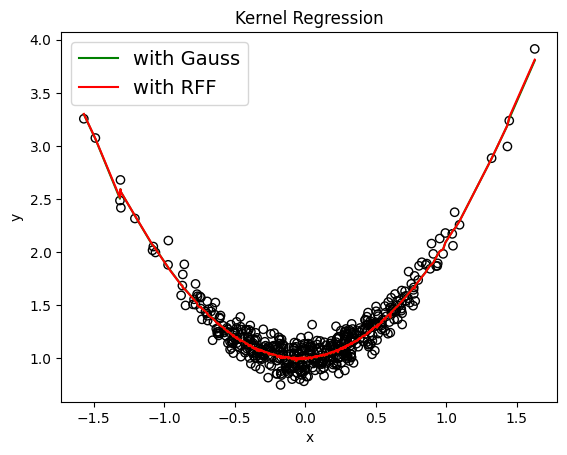

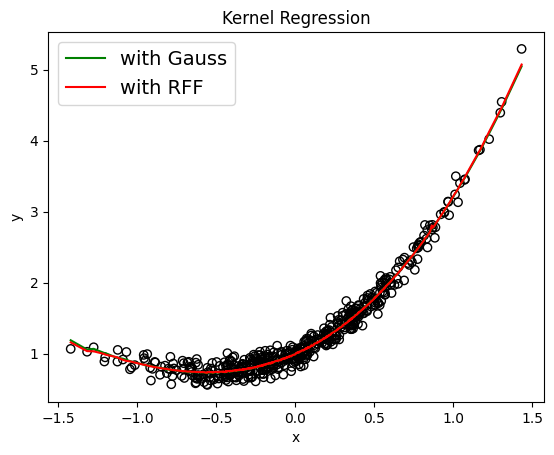

In [11]:
# Plot for x1 and y1
f1_sort_approx = np.array([x for _,x in sorted(zip(x1,function_estimate[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x1), f1_sort, c="g", label="with Gauss")
plt.plot(np.sort(x1), f1_sort_approx, c="r", label="with RFF")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort_approx = np.array([x for _,x in sorted(zip(x2,function_estimate[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x2), f2_sort, c="g", label="with Gauss")
plt.plot(np.sort(x2), f2_sort_approx, c="r", label="with RFF")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()